<a href="https://colab.research.google.com/github/ZiadMotagaly/photogram/blob/main/Photogrammetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

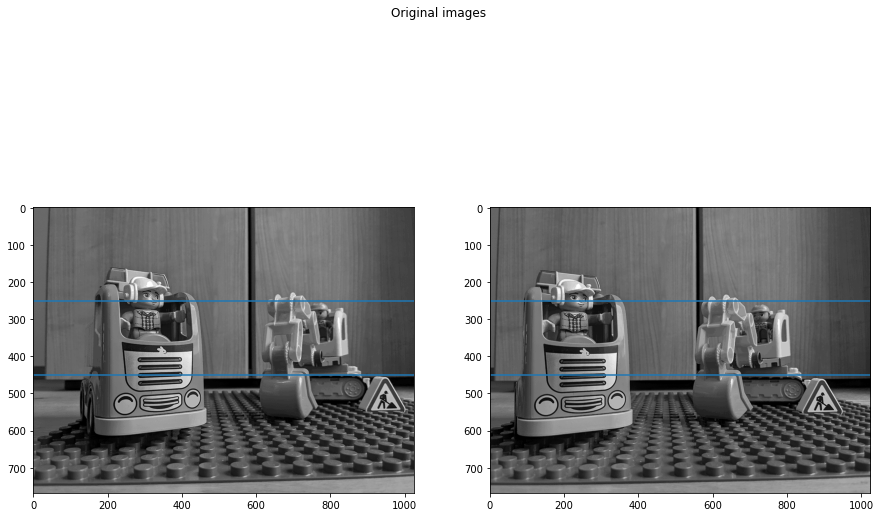

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Read both images and convert to grayscale
img1 = cv.imread('left_img.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('right_img.png', cv.IMREAD_GRAYSCALE)

# ------------------------------------------------------------
# PREPROCESSING

# Compare unprocessed images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1, cmap="gray")
axes[1].imshow(img2, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Original images")
plt.savefig("original_images.png")
plt.show()

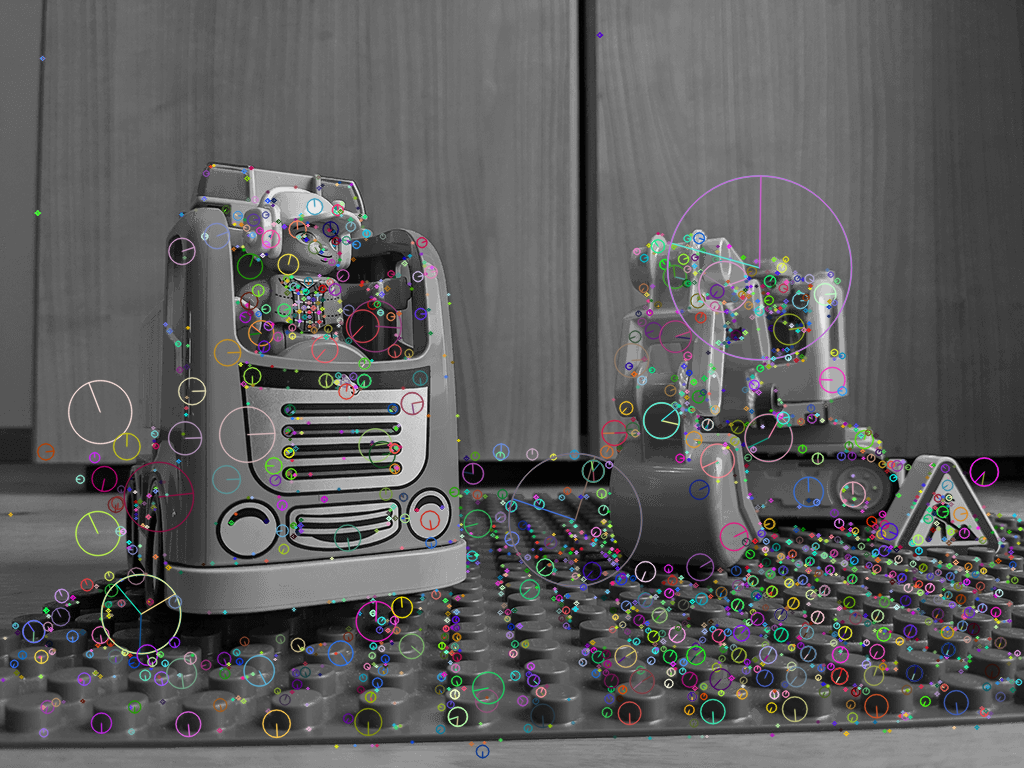

True

In [ ]:
# 1. Detect keypoints and their descriptors
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Visualize keypoints
imgSift = cv.drawKeypoints(
    img1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2_imshow(imgSift)
cv.imwrite("sift_keypoints.png", imgSift)


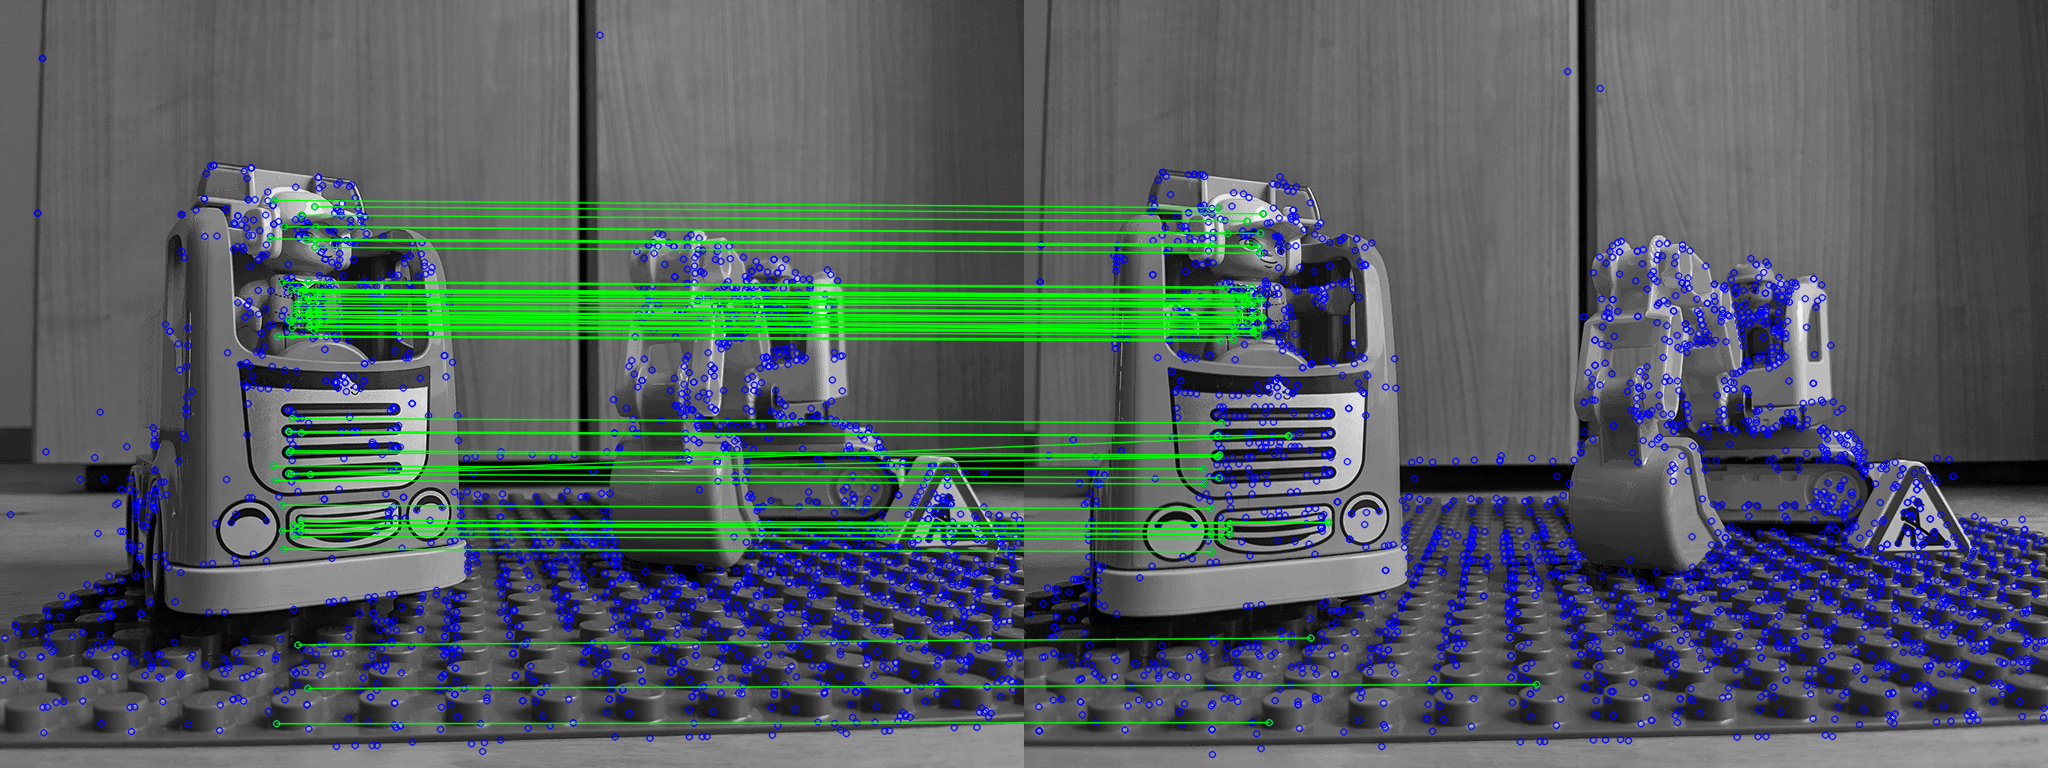

True

In [ ]:
# Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

# Draw the keypoint matches between both pictures
# Still based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, matches[300:500], None, **draw_params)
cv2_imshow(keypoint_matches)
cv.imwrite("keypoint_matches.png", keypoint_matches)

In [ ]:
# Calculate the fundamental matrix for the cameras
# https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

In [ ]:
# Visualize epilines
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html


def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color

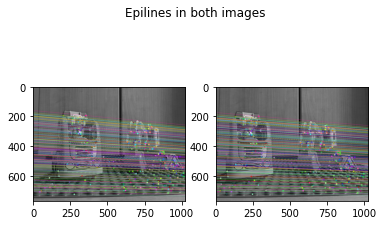

In [ ]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.savefig("epilines.png")
plt.show()

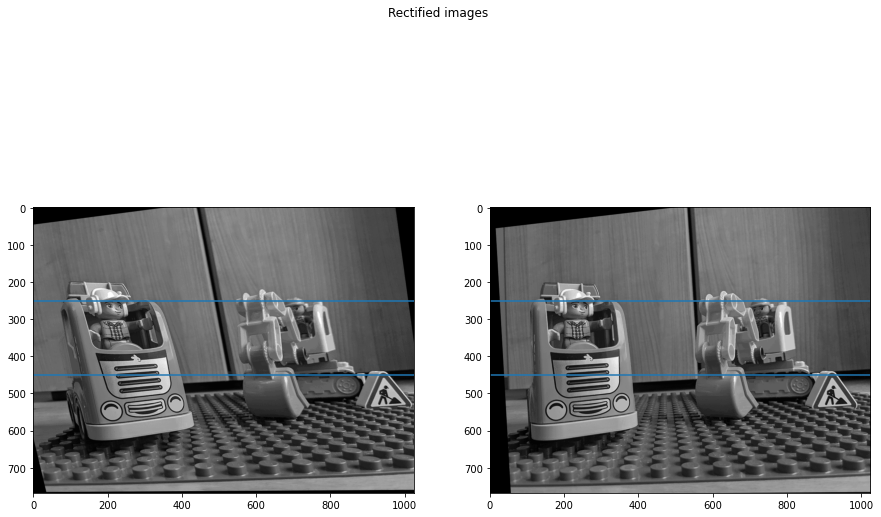

In [ ]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

# Rectify (undistort) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))
cv.imwrite("rectified_1.png", img1_rectified)
cv.imwrite("rectified_2.png", img2_rectified)

# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()

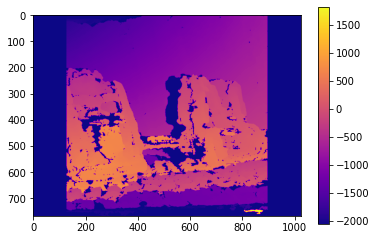

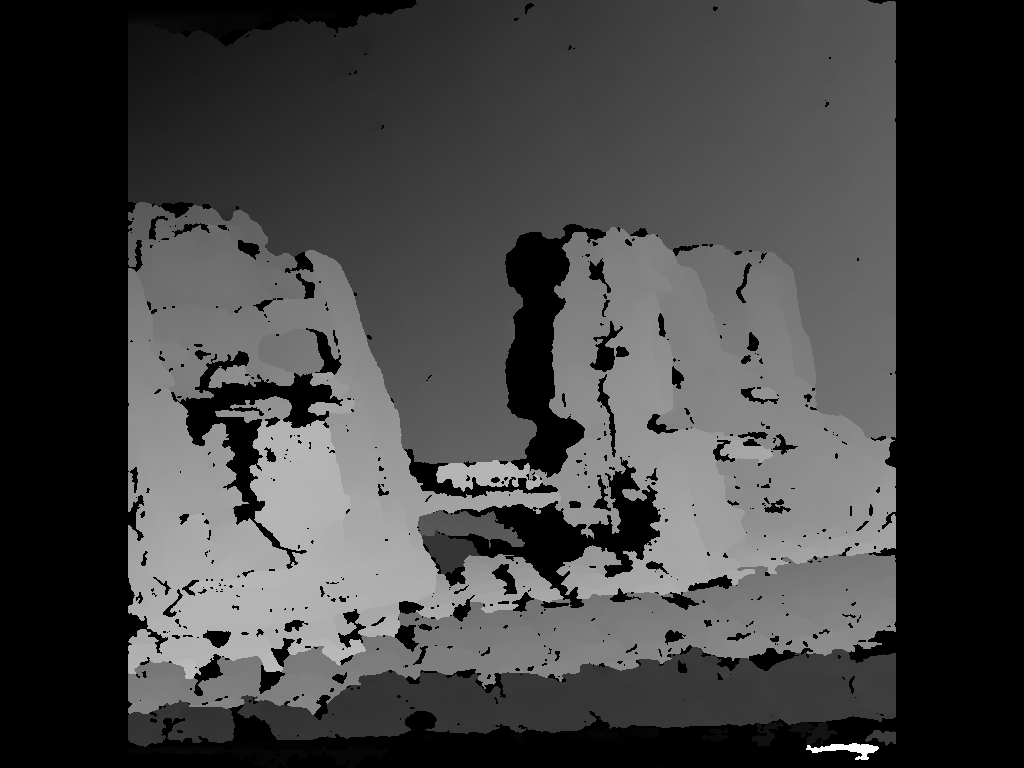

In [ ]:
# CALCULATE DISPARITY (DEPTH MAP)
# Adapted from: https://github.com/opencv/opencv/blob/master/samples/python/stereo_match.py
# and: https://docs.opencv.org/master/dd/d53/tutorial_py_depthmap.html

# StereoSGBM Parameter explanations:
# https://docs.opencv.org/4.5.0/d2/d85/classcv_1_1StereoSGBM.html

# Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
block_size = 11
min_disp = -128
max_disp = 128
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 5
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize = 200
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 2
disp12MaxDiff = 0

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)

disparity_SGBM = stereo.compute(img1_rectified, img2_rectified)

plt.imshow(disparity_SGBM, cmap='plasma')
plt.colorbar()
plt.show()

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)
cv2_imshow(disparity_SGBM)
cv.imwrite("disparity_SGBM_norm.png", disparity_SGBM)


cv.waitKey()
cv.destroyAllWindows()
# ---------------------------------------------------------------

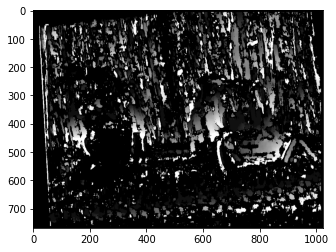

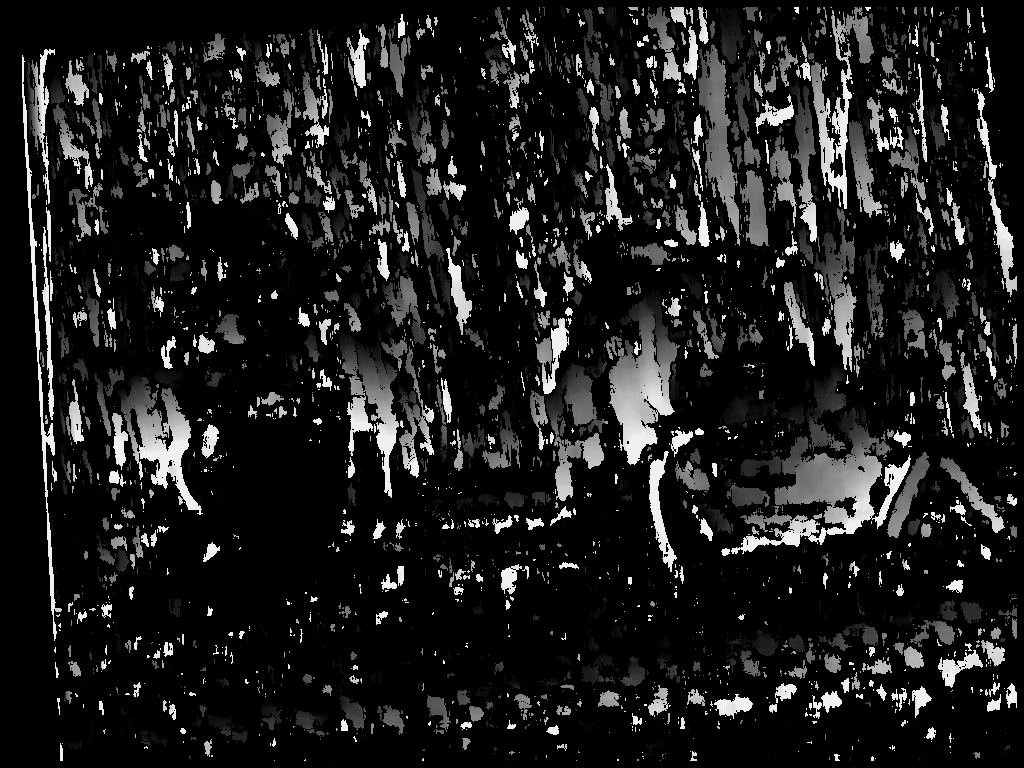

In [ ]:
stereo2 = cv.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo2.compute(img1_rectified, img2_rectified)
plt.imshow(disparity,'gray')
plt.show()
cv.imwrite("disparity.png", disparity)

#disparity = cv.normalize(disparity, disparity, alpha=255,
#                              beta=0, norm_type=cv.NORM_MINMAX)
#disparity = np.uint8(disparity_SGBM)
cv2_imshow(disparity)


cv.waitKey()
cv.destroyAllWindows()

In [ ]:
!pip3 install open3d


In [ ]:
import imageio as iio
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

# Read depth image:
depth_image = iio.imread('/content/disparity.png')

# print properties:
print(f"Image resolution: {depth_image.shape}")
print(f"Data type: {depth_image.dtype}")
print(f"Min value: {np.min(depth_image)}")
print(f"Max value: {np.max(depth_image)}")

Image resolution: (768, 1024)
Data type: uint8
Min value: 0
Max value: 240


In [ ]:
color_raw =o3d.io.read_image('left_img.png')
depth_raw =o3d.io.read_image('disparity.png')

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw,depth_raw)
print(rgbd_image)


RGBDImage of size 
Color image : 1024x768, with 1 channels.
Depth image : 1024x768, with 1 channels.
Use numpy.asarray to access buffer data.


In [ ]:
camera_intrinsic= o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

In [ ]:
pcd= o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,camera_intrinsic)

o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
rgb_image = iio.imread('/content/left_img.png')


In [ ]:
h, w = rgb_image.shape[:2]
f = 0.8 * w  # guess for focal length
Q = np.float32([[1, 0, 0, -0.5 * w],
                [0, -1, 0, 0.5 * h],  # turn points 180 deg around x-axis,
                [0, 0, 0, -f],  # so that y-axis looks up
                [0, 0, 1, 0]])

M = np.zeros((4,4))


In [ ]:
point_cloud = cv.reprojectImageTo3D(disparity,M)
point_cloud = point_cloud.reshape(-1, point_cloud.shape[-1])
point_cloud = point_cloud[~np.isinf(point_cloud).any(axis=1)]

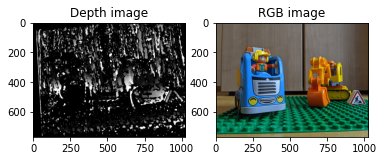

In [ ]:

# Display depth and grayscale image:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(disparity, cmap="gray")
axs[0].set_title('Depth image')
axs[1].imshow(rgb_image)
axs[1].set_title('RGB image')
plt.show()

In [ ]:
!pip3 install pypotree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


::ffff:127.0.0.1 - - [08/Dec/2022 20:00:44] "GET /point_clouds/libs/other/BinaryHeap.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [08/Dec/2022 20:00:44] "GET /point_clouds/libs/tween/tween.min.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [08/Dec/2022 20:00:45] "GET /point_clouds/libs/d3/d3.js HTTP/1.1" 200 -
::ffff:127.0.0.1 - - [08/Dec/2022 20:00:46] "GET /point_clouds/libs/proj4/proj4.js HTTP/1.1" 200 -


In [ ]:
import pypotree
import numpy as np

cloudpath = pypotree.generate_cloud_for_display(point_cloud)
pypotree.display_cloud_colab(cloudpath)

/usr/local/lib/python3.8/dist-packages/bin/PotreeConverter .tmp.txt -f xyz -o point_clouds -p 442aa1 --material ELEVATION --edl-enabled --overwrite
server on port 23621: thread <Thread(Thread-12, started 140072012154624)> 
https://localhost:23621/point_clouds/pointclouds/442aa1
